구글 드라이브에서 데이터를 받아와서 리턴을 계산

In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from tqdm import tqdm

In [29]:
# raw_data를 불러와서 메모리에 올립니다
lst = os.listdir("gecko_drive") # 여기에다가 로컬 데이터 폴더 경로 지정
coin_price_dict = {}
coin_marketcap_dict = {}
coin_volume_dict = {}
error_list = []

for file in tqdm(lst):
    try:
        df = pd.read_csv("gecko_drive/{}".format(file), index_col=0)
        coin_price_dict[file] = df[["prices"]]
        coin_marketcap_dict[file] = df[["market_caps"]]
        coin_volume_dict[file] = df[["total_volumes"]]
    except:
        error_list.append(file)
        print("{} Open Error!!".format(file))
        continue
print("Done... Error file is saved in error_list")

In [3]:
# 데이터를 하나의 DataFrame으로 합쳐줍니다

# find the longest timeframe index
longest_index_price = max([df.index for df in coin_price_dict.values()], key=len)
longest_index_cap = max([df.index for df in coin_marketcap_dict.values()], key=len)
longest_index_vol = max([df.index for df in coin_volume_dict.values()], key=len)

# create a close dataframe with the longest timeframe index and columns "key1", "key2", "key3"
price_df = pd.DataFrame(index=longest_index_price, columns=coin_price_dict.keys())
market_cap_df = pd.DataFrame(index=longest_index_cap, columns=coin_marketcap_dict.keys())
volume_df = pd.DataFrame(index=longest_index_vol, columns=coin_volume_dict.keys())

for key, df in tqdm(coin_price_dict.items()):
    # use groupby and last to select the last value for each index
    df = df.astype("float64")
    price_df[key] = df.groupby(df.index).last().reindex(longest_index_price)

for key, df in tqdm(coin_marketcap_dict.items()):
    df2 = df.astype("float64")
    market_cap_df[key] = df2.groupby(df2.index).last().reindex(longest_index_cap)

for key, df in tqdm(coin_volume_dict.items()):
    df = df.astype("float64")
    volume_df[key] = df.groupby(df.index).last().reindex(longest_index_vol)

100%|██████████| 1485/1485 [00:13<00:00, 110.15it/s]


In [16]:
# Datetime으로 index를 변경
price_df.index = pd.to_datetime(price_df.index)
market_cap_df.index = pd.to_datetime(market_cap_df.index)
#volume_df.index = pd.to_datetime(volume_df.index)

In [17]:
# 시총으로 weight를 계산
weight = market_cap_df.apply(lambda x: x / np.nansum(x), axis=1)

# 수익률 데이터프레임 생성
return_df = price_df.pct_change(7)

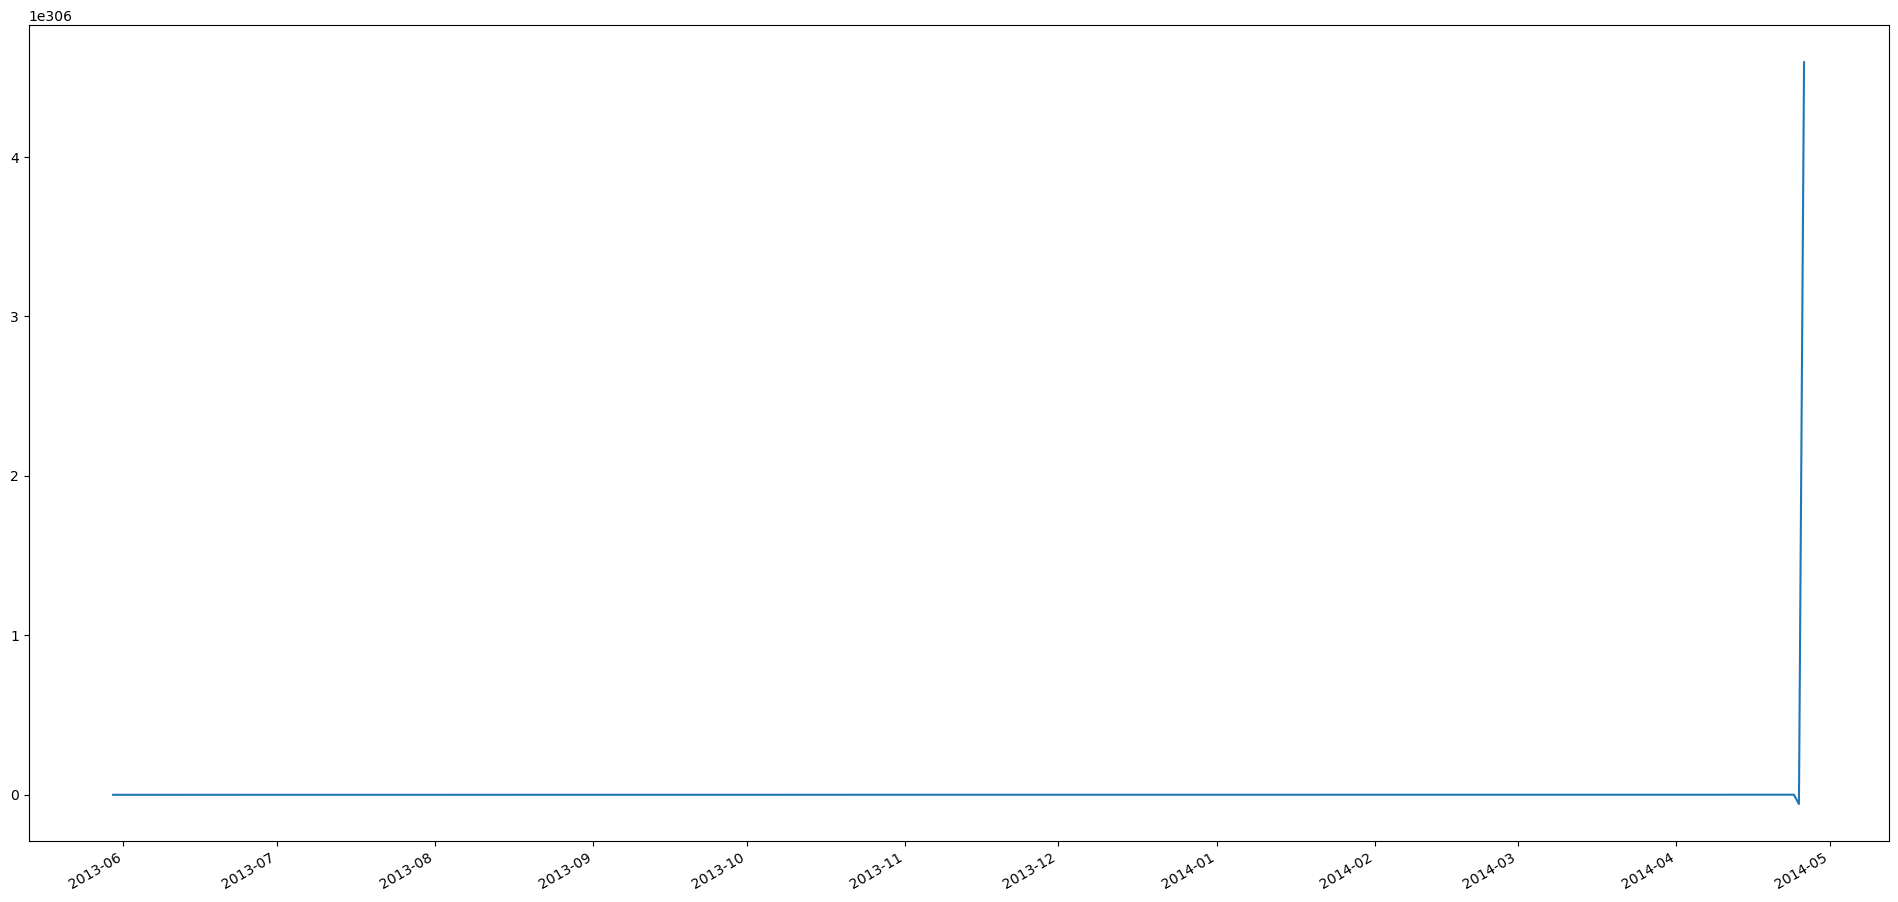

In [18]:
# weight * 리턴 (Without screening)
((return_df * price_df).mean(axis=1) + 1).cumprod().plot(figsize=(24,12));

In [19]:
market_cap_df["BTC"]

2013-05-02    1.285259e+09
2013-05-08    1.274466e+09
2013-05-11    1.312275e+09
2013-05-23    1.389587e+09
2013-05-27    1.500504e+09
                  ...     
2022-12-27    3.243871e+11
2022-12-28    3.207847e+11
2022-12-29    3.176410e+11
2022-12-30    3.191386e+11
2022-12-31    3.184147e+11
Name: BTC, Length: 3494, dtype: float64

In [20]:
# 시총으로 screening (1,000,000달러 이상)
screener = np.where(market_cap_df > 1_000_000, 1, np.nan)
screener_df = pd.DataFrame(screener, index=market_cap_df.index,
                           columns=market_cap_df.columns)

# 스크리닝 후, 스크린한 것들로만 시가총액 가중 weight를 구함
screened_weight = (screener_df * market_cap_df).apply(lambda x: x / np.nansum(x), axis=1)

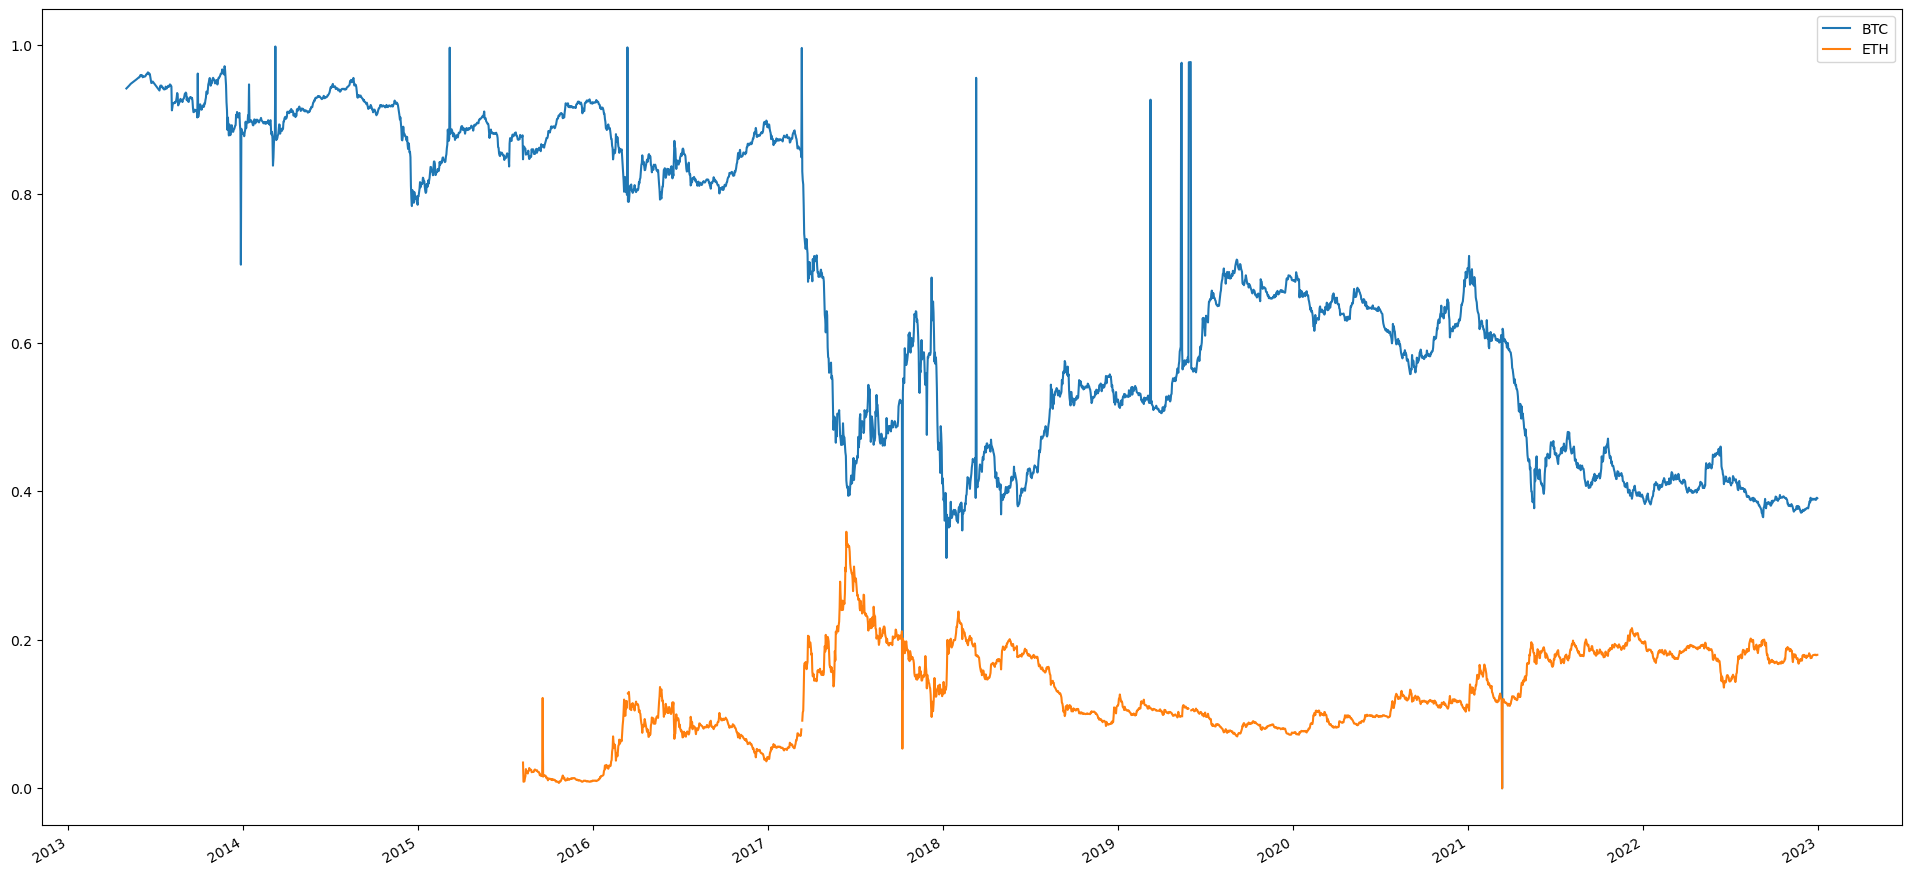

In [25]:
screened_weight[["BTC", "ETH"]].plot(figsize=(24,12));

In [26]:
# 상장된 코인 수가 중간에 0이 되는 데이터 문제 수정을 위해서
market_cap_df_ffill = market_cap_df.ffill()

# 시총으로 screening (1,000,000달러 이상)
screener = np.where(market_cap_df_ffill > 1_000_000, 1, np.nan)
screener_df = pd.DataFrame(screener, index=market_cap_df_ffill.index,
                           columns=market_cap_df_ffill.columns)

# 스크리닝 후, 스크린한 것들로만 시가총액 가중 weight를 구함
screened_weight = (screener_df * market_cap_df).apply(lambda x: x / np.nansum(x), axis=1)

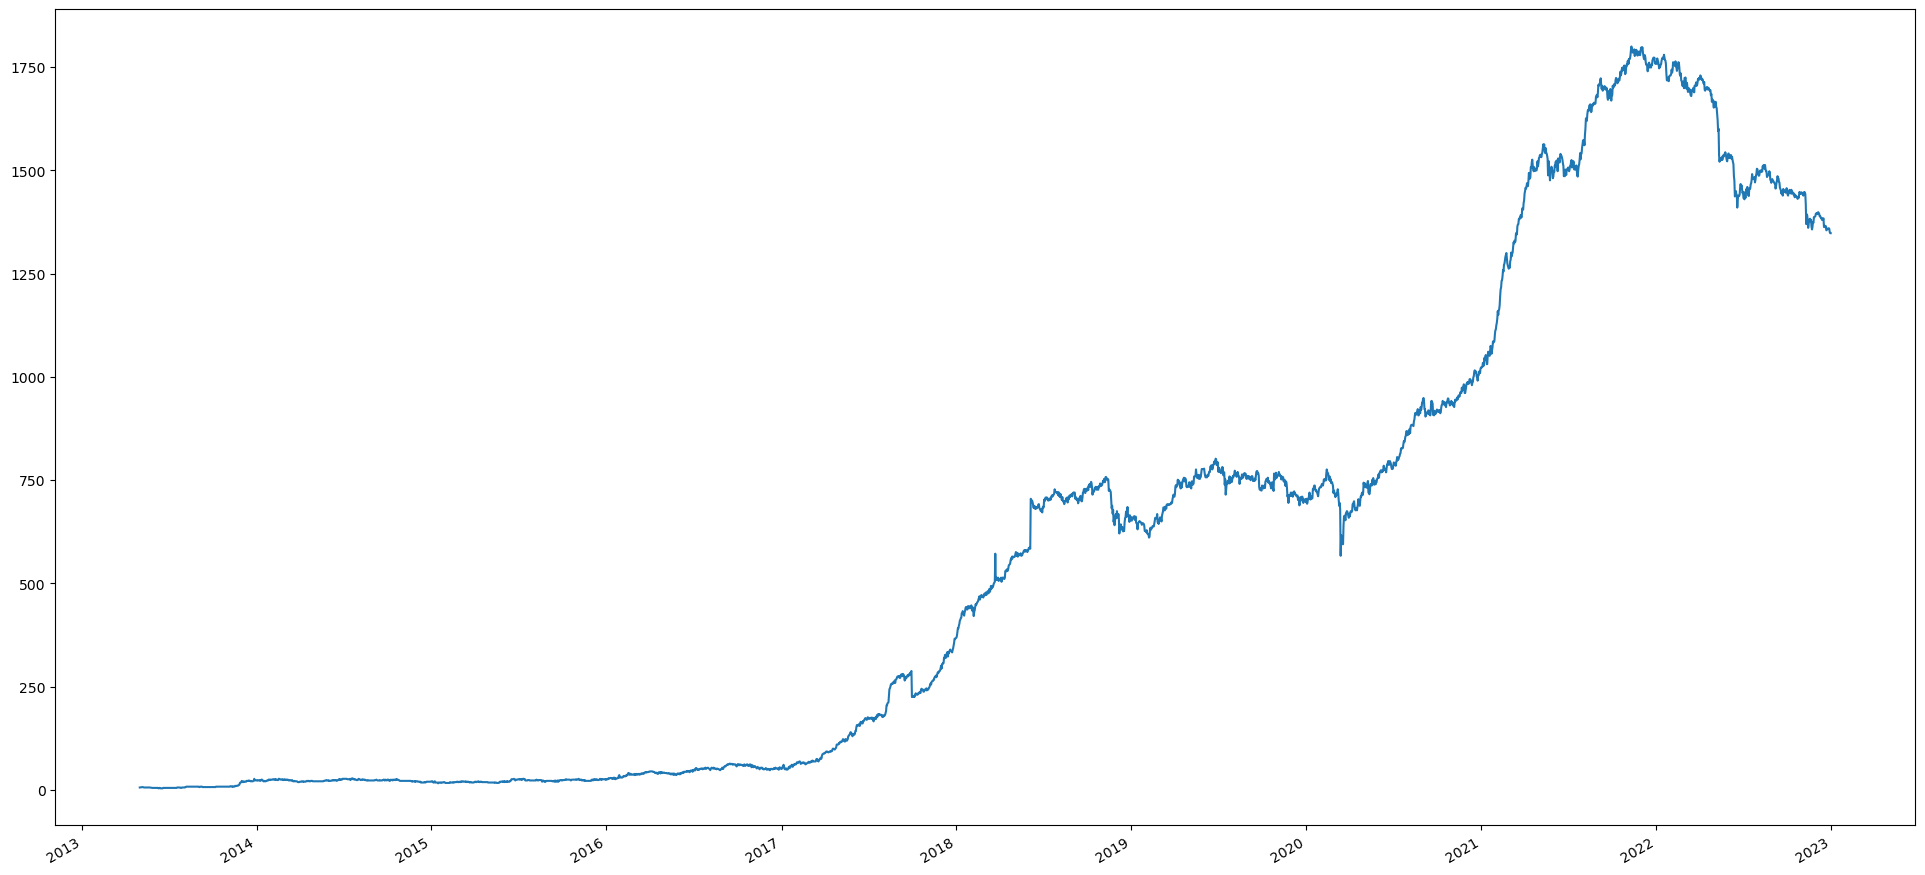

In [27]:
# ffill을 하고, 스크리닝 한 종목 수를 출력 (수익률 아님!!)
screener_df.count(axis=1).plot(figsize=(24,12));

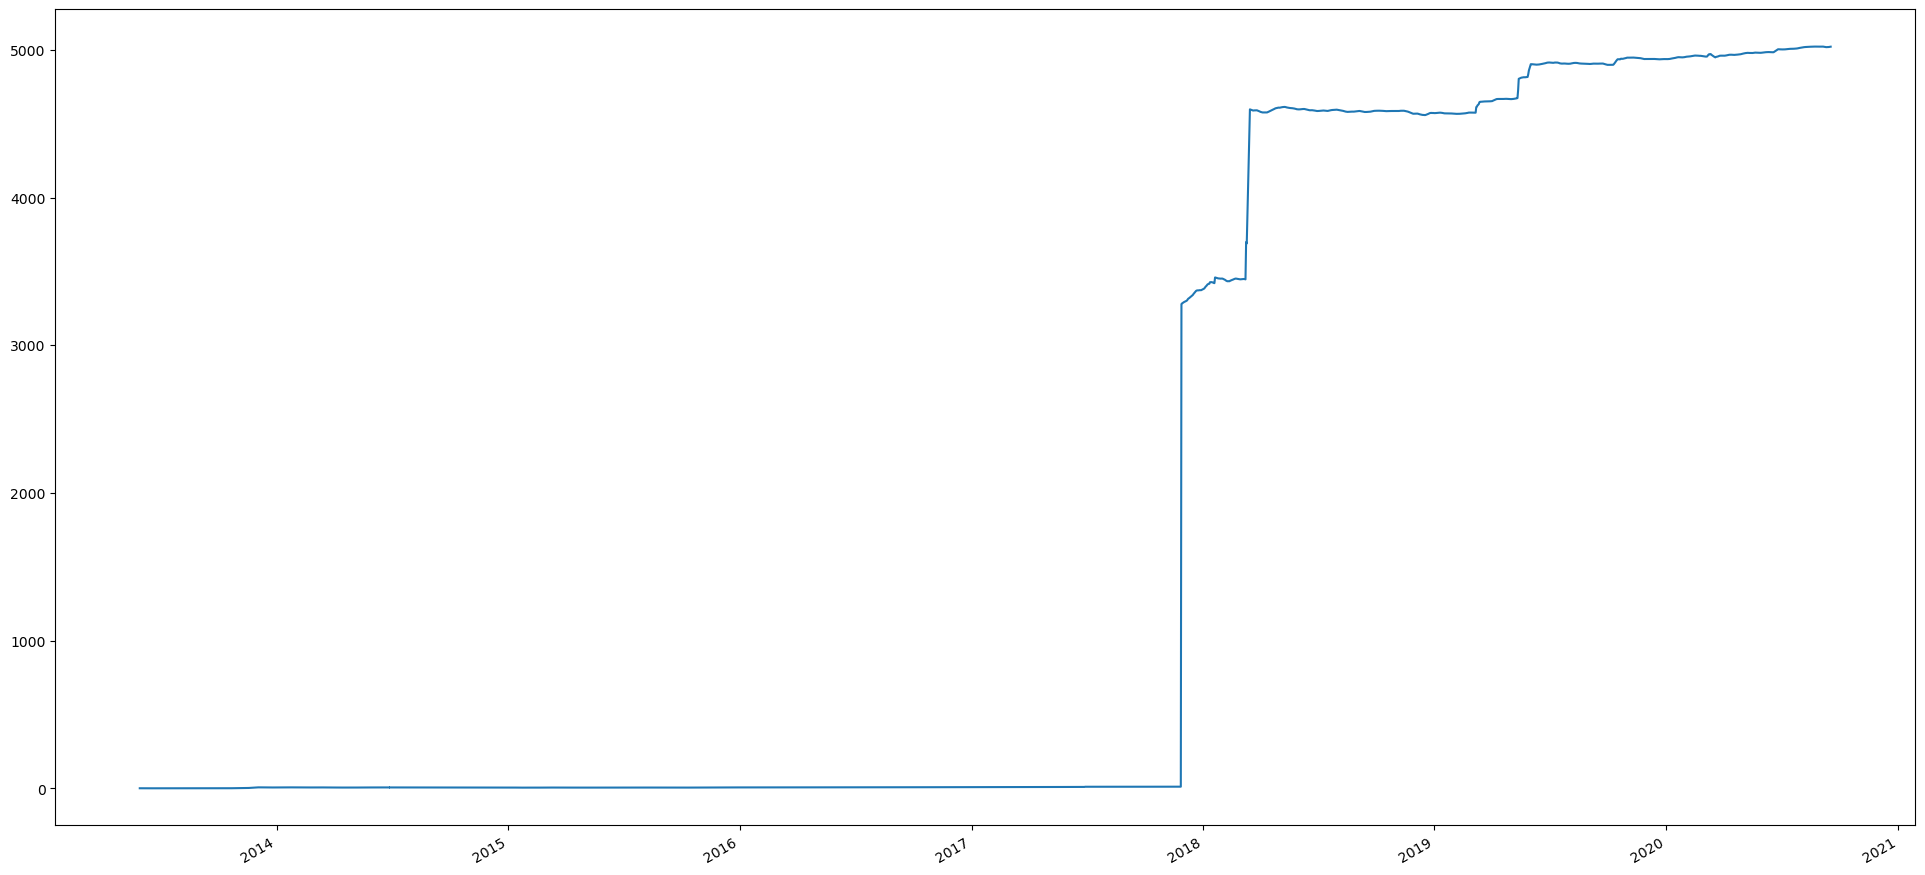

In [28]:
# 스크리닝하고, 시가총액으로 가중평균한 수익률
((return_df * screened_weight).mean(axis=1) + 1).cumprod().plot(figsize=(24,12));